In [1]:
# import packages
from imports import *
from models import *
from preprocessing import *
from myLogger import myLog
from sklearn.ensemble import VotingRegressor 
from sklearn.ensemble import BaggingRegressor   
from sklearn.ensemble import StackingRegressor  
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import colorama
from colorama import Fore, Back, Style

import warnings
warnings.filterwarnings("ignore")

# A brief summary of the dataset

In [3]:
# READING THE DATA
df_raw = pd.read_csv("./data/archive/ds_salaries.csv")
df_raw = df_raw[['work_year', 'experience_level', 'job_title', 'salary_in_usd', 'company_location', 'employee_residence', 'company_size']]
df_raw.columns = ['year', 'exp', 'title', 'raw_salary','company_loc', 'emp_loc', 'company_size']

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          607 non-null    int64 
 1   exp           607 non-null    object
 2   title         607 non-null    object
 3   raw_salary    607 non-null    int64 
 4   company_loc   607 non-null    object
 5   emp_loc       607 non-null    object
 6   company_size  607 non-null    object
dtypes: int64(2), object(5)
memory usage: 33.3+ KB


In [4]:
# LOGGING
logger = myLog()

NUMERICAL_FEATURES = ['raw_salary']
CATEGORICAL_FEATURES = ['year', 'exp', 'title','company_loc', 'company_size']


Column Name : raw_salary

count      607.00
mean    112297.87
std      70957.26
min       2859.00
5%       20000.00
10%      33689.20
20%      54957.00
30%      71337.60
40%      87932.00
50%     101570.00
60%     120000.00
70%     140000.00
80%     160000.00
90%     200000.00
95%     220110.00
99%     403500.00
max     600000.00
Name: raw_salary, dtype: float64


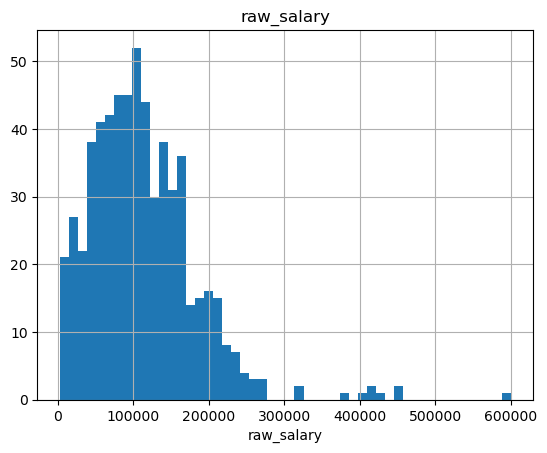

In [5]:
## Visualize the numerical features
def num_summary(dataframe, numerical_col, plot=True):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in NUMERICAL_FEATURES:
    print(Back.CYAN)
    print(f'Column Name : {col}')
    print(Style.RESET_ALL)
    num_summary(df_raw, col)


Column Name : year

      year  Ratio
2022   318  52.39
2021   217  35.75
2020    72  11.86


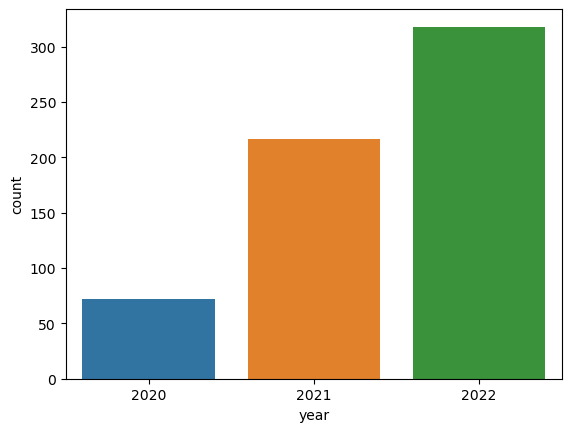


Column Name : exp

    exp  Ratio
SE  280  46.13
MI  213  35.09
EN   88  14.50
EX   26   4.28


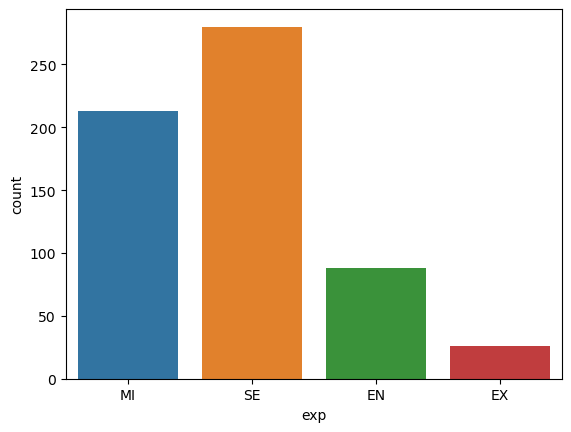


Column Name : title

                                          title  Ratio
Data Scientist                              143  23.56
Data Engineer                               132  21.75
Data Analyst                                 97  15.98
Machine Learning Engineer                    41   6.75
Research Scientist                           16   2.64
Data Science Manager                         12   1.98
Data Architect                               11   1.81
Big Data Engineer                             8   1.32
Machine Learning Scientist                    8   1.32
Principal Data Scientist                      7   1.15
AI Scientist                                  7   1.15
Data Science Consultant                       7   1.15
Director of Data Science                      7   1.15
Data Analytics Manager                        7   1.15
ML Engineer                                   6   0.99
Computer Vision Engineer                      6   0.99
BI Data Analyst                            

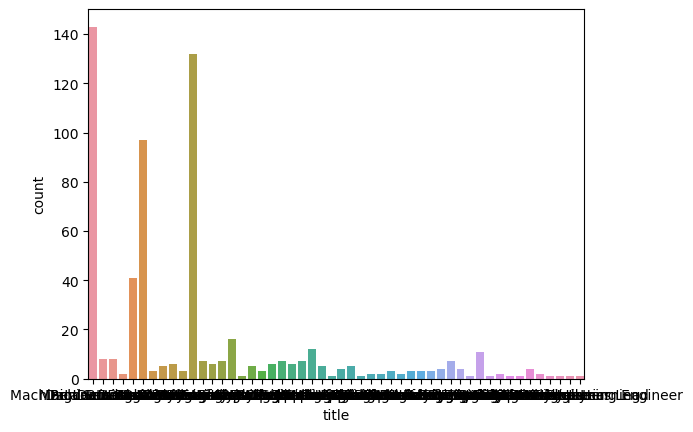


Column Name : company_loc

    company_loc  Ratio
US          355  58.48
GB           47   7.74
CA           30   4.94
DE           28   4.61
IN           24   3.95
FR           15   2.47
ES           14   2.31
GR           11   1.81
JP            6   0.99
NL            4   0.66
AT            4   0.66
PT            4   0.66
PL            4   0.66
LU            3   0.49
PK            3   0.49
BR            3   0.49
AE            3   0.49
MX            3   0.49
AU            3   0.49
TR            3   0.49
DK            3   0.49
IT            2   0.33
CZ            2   0.33
SI            2   0.33
RU            2   0.33
CH            2   0.33
NG            2   0.33
CN            2   0.33
BE            2   0.33
VN            1   0.16
EE            1   0.16
AS            1   0.16
DZ            1   0.16
MY            1   0.16
MD            1   0.16
KE            1   0.16
SG            1   0.16
CO            1   0.16
IR            1   0.16
CL            1   0.16
MT            1   0.16
IL    

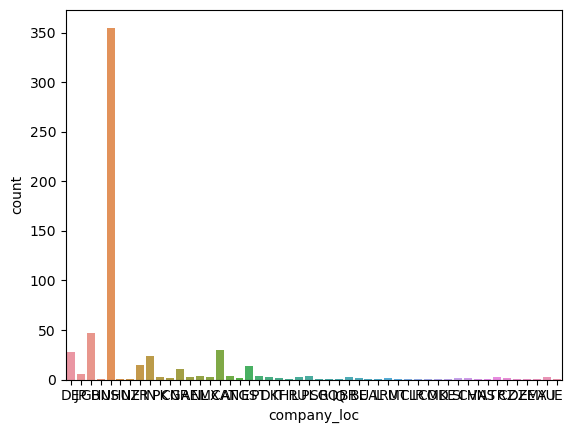


Column Name : company_size

   company_size  Ratio
M           326  53.71
L           198  32.62
S            83  13.67


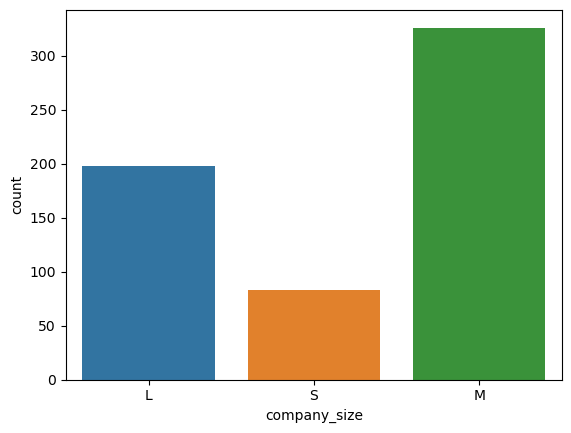

In [6]:
## Visualize the categorical features
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in CATEGORICAL_FEATURES:
    print(Back.RED)
    print(f'Column Name : {col}')
    print(Style.RESET_ALL)
    cat_summary(df_raw, col,plot=True)

In [7]:

EXP2 = False
EXP4B = False

data_mean, data_std = np.mean(df_raw['raw_salary']), np.std(df_raw['raw_salary'])

# IDENTIFYING AND REMOVING OUTLIERS
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
nonoutliers = [x for x in df_raw['raw_salary'] if x < upper]
outliers = [x for x in df_raw['raw_salary'] if x > upper]
df_raw['salary'] = df_raw['raw_salary'].apply(lambda x: x if x <= upper else upper)


In [8]:
print("The number of outliers is", len(outliers))
df_raw.loc[df_raw['raw_salary'] > upper]

The number of outliers is 16


,year,exp,title,raw_salary,company_loc,emp_loc,company_size,salary
1,2020,SE,Machine Learning Scientist,260000,JP,JP,S,254095.44
25,2020,EX,Director of Data Science,325000,US,US,L,254095.44
33,2020,MI,Research Scientist,450000,US,US,M,254095.44
63,2020,SE,Data Scientist,412000,US,US,L,254095.44
78,2021,MI,ML Engineer,270000,US,US,L,254095.44
93,2021,SE,Lead Data Engineer,276000,US,US,L,254095.44
97,2021,MI,Financial Data Analyst,450000,US,US,L,254095.44
157,2021,MI,Applied Machine Learning Scientist,423000,US,US,L,254095.44
225,2021,EX,Principal Data Scientist,416000,US,US,S,254095.44
231,2021,SE,ML Engineer,256000,US,US,S,254095.44


In [61]:
df_raw[['salary','raw_salary']].describe()

,salary,raw_salary
count,607.00,607.00
mean,109484.24,112297.87
std,60749.46,70957.26
min,2859.00,2859.00
25%,62726.00,62726.00
50%,101570.00,101570.00
75%,150000.00,150000.00
max,254095.44,600000.00


In [9]:
# PREPROCESSING CLASS
df = Preprocessor(df_raw, verbose=EXP2).preproc().reset_index(drop=True)
df.info()

In [20]:
# df = df.loc[df['raw_salary'] < upper]
Y = df[['salary']]
X = df.drop(['salary'], axis=1)

In [24]:
verbose2 = True
xTrain, xTest, yTrain, yTest = tts(X, Y, test_size=0.2, shuffle=True)
svr, svr_preds =  SVMModel(xTrain, xTest, yTrain, yTest, 'poly', verbose2)
knn, knn_preds = KNNModel(xTrain, xTest, yTrain, yTest, verbose2)
rfc, rfc_preds = RFCModel(xTrain, xTest, yTrain, yTest, 50, verbose2)


| | 
| | SVM: LINEAR
| | | 
| | | MSE is: 3726229200.442638
| | | 
| | | MAE is 49944.96313934231
| | | 
| | | Score is: -0.008792590090127783

| | 
| | K-NEAREST NEIGHBOURS
| | | 
| | | MSE is: 1970446186.1319237
| | | 
| | | MAE is 34318.549280486826
| | | 
| | | Score is: 0.4665460966531231
| | 
| | RANDOM FOREST
| | | 
| | | MSE is: 1960592949.260615
| | | 
| | | MAE is 31453.24194079317
| | | 
| | | Score is: 0.4692136385056205


In [25]:
verbose3 = True
linear, lr_preds = LinRegModel(xTrain, xTest, yTrain, yTest, verbose3)
lasso, lasso_preds = LassoRegModel(xTrain, xTest, yTrain, yTest, 10, verbose3)
ridge, ridge_preds = RidgeRegModel(xTrain, xTest, yTrain, yTest, 'lsqr', 0, verbose3)

| | 
| | LINEAR REGRESSION
| | | 
| | | MSE is: 5.1235001823955284e+32
| | | 
| | | MAE is 3990365845208401.5
| | | 
| | | Score is: -1.387072222694207e+23

--------------------     Lasso Reg      --------------------
 MSE is: 2657021107.538313
 MAE is 36037.958036278695
 Score is: 0.2806714077922762


--------------------     Ridge Reg      --------------------
 MSE is: 2632182762.2826157
 MAE is 36173.56657800303
 Score is: 0.28739583006911074



In [57]:

nrounds = 0
results = []
verbose = False
xTrain, xTest, yTrain, yTest = tts(X, Y, test_size=0.2, shuffle=True)
svr, svr_preds =  SVMModel(xTrain, xTest, yTrain, yTest, 'poly', verbose)
    # regr = BaggingRegressor(linear)
knn, knn_preds = KNNModel(xTrain, xTest, yTrain, yTest, verbose)
rfc, rfc_preds = RFCModel(xTrain, xTest, yTrain, yTest, 500, verbose)
linear, lr_preds = LinRegModel(xTrain, xTest, yTrain, yTest, verbose)
lasso, lasso_preds = LassoRegModel(xTrain, xTest, yTrain, yTest, 10, verbose)
ridge, ridge_preds = RidgeRegModel(xTrain, xTest, yTrain, yTest, 'lsqr', 0, verbose)
ensemble = VotingRegressor([('lasso', lasso), ('ridge', ridge)])
ensemble.fit(xTrain, yTrain)
yHat = ensemble.predict(xTest)
# val_mae = mae(yHat, yTest)
# results.append(val_mae)
nrounds += 1
# test_value = np.average(results)
test_value = val_mae
# print(f"{nrounds}\t{svr.score(xTest, yTest):4f}\t{knn.score(xTest, yTest):4f}\t{rfc.score(xTest, yTest):4f}\t{ensemble.score(xTest, yTest):4f}")


In [58]:
columns =['Target', 'SVR', 'RFC', 'LR', 'LASSO', 'RIDGE', 'ENSEMBLE']
df_cmp = pd.DataFrame(list(zip(yTest.values.squeeze(), svr_preds, rfc_preds, lr_preds.squeeze(), lasso_preds, ridge_preds.squeeze(), yHat)),columns = columns)

In [59]:
df_cmp

,Target,SVR,RFC,LR,LASSO,RIDGE,ENSEMBLE
0,254095.44,110334.04,121117.47,116224.00,119594.39,120976.91,120285.65
1,177000.00,110693.79,221979.49,213504.00,188594.91,208104.47,198349.69
2,170000.00,110756.71,165315.06,151552.00,152575.58,152197.53,152386.55
3,147000.00,110348.30,118274.43,138240.00,140175.65,139938.95,140057.30
4,148261.00,110306.10,129362.46,147968.00,152638.64,152463.21,152550.92
...,...,...,...,...,...,...,...
97,220110.00,110727.33,138158.31,145920.00,147005.92,146770.06,146887.99
98,230000.00,110756.71,165315.06,151552.00,152575.58,152197.53,152386.55
99,136994.00,110727.33,138158.31,145920.00,147005.92,146770.06,146887.99
100,70500.00,110727.33,138158.31,145920.00,147005.92,146770.06,146887.99


In [60]:
df_cmp.sum()

Target                 12891954.88
SVR                    11271245.38
RFC                    11694650.66
LR         -5878087175038654464.00
LASSO                  12298812.03
RIDGE                  12155074.75
ENSEMBLE               12226943.39
dtype: float64

In [68]:
test_columns =['SVR', 'RFC', 'LR', 'LASSO', 'RIDGE', 'ENSEMBLE']
print("MAE for the models above:")
print("="*30)
for col in test_columns:
    print(col, "\t", mae(df_cmp.Target, df_cmp[[col]]))

MAE for the models above:
SVR 	 44227.1432892763
RFC 	 28516.331480213263
LR 	 5.762830563778229e+16
LASSO 	 29878.602347082524
RIDGE 	 29765.848193450667
ENSEMBLE 	 29506.500440721353


In [70]:
print("R2 for the models above:")
print("="*30)
for col in test_columns:
    print(col, "\t", r2_score(df_cmp.Target, df_cmp[[col]]))

R2 for the models above:
SVR 	 -0.08725030189147764
RFC 	 0.438213759539667
LR 	 -1.2133323420023219e+26
LASSO 	 0.43888584059807967
RIDGE 	 0.4338774174771657
ENSEMBLE 	 0.4444136182127203
